<a href="https://colab.research.google.com/github/merveenoyan/siglip/blob/main/siglip_faiss_indexing_and_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Embeddings with SigLIP

This notebook walks you through how to use SigLIP model to get embeddings and index them using FAISS to later use them for search.
Let's install necessary libraries.

In [1]:
!pip install datasets faiss-gpu git+https://github.com/NielsRogge/transformers.git@add_siglip sentencepiece

  Cloning https://github.com/NielsRogge/transformers.git (to revision add_siglip) to /tmp/pip-req-build-03x0qro5
  Running command git clone --filter=blob:none --quiet https://github.com/NielsRogge/transformers.git /tmp/pip-req-build-03x0qro5
  Running command git checkout -b add_siglip --track origin/add_siglip
  Switched to a new branch 'add_siglip'
  Branch 'add_siglip' set up to track remote branch 'add_siglip' from 'origin'.
  Resolved https://github.com/NielsRogge/transformers.git to commit 8c83814b8e468c5e83260203744d7ad0818c836c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.5/85.5 MB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 71.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.8 MB/s eta 0:00:

We will now initialize the model.

In [25]:
#Import packages
import torch
from PIL import Image
from transformers import AutoProcessor, SiglipModel, AutoImageProcessor, AutoModel, AutoTokenizer
import faiss
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else "cpu")

model = SiglipModel.from_pretrained("nielsr/siglip-base-patch16-224").to(device)
processor = AutoProcessor.from_pretrained("nielsr/siglip-base-patch16-224")
tokenizer = AutoTokenizer.from_pretrained("nielsr/siglip-base-patch16-224")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:72: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Load the dataset. Since this is a toy example, to keep the notebook light, we will load small chunk of the train split using datasets server.

In [27]:
import requests
# insert your HF token here
headers = {"Authorization": f"Bearer {API_TOKEN}"}
API_URL = "https://datasets-server.huggingface.co/rows?dataset=huggan/wikiart&config=default&split=train&offset=1&length=100"
def query():
    response = requests.get(API_URL, headers=headers)
    return response.json()
data = query()

See an example of what's returned and how to get the image itself.

In [28]:
data["rows"][0]

{'row_idx': 1,
 'row': {'image': {'src': 'https://datasets-server.huggingface.co/cached-assets/huggan/wikiart/--/d559852d2b232e0fcf195e775866964f0564f2b5/--/default/train/1/image/image.jpg',
   'height': 1659,
   'width': 1382},
  'artist': 20,
  'genre': 7,
  'style': 4},
 'truncated_cells': []}

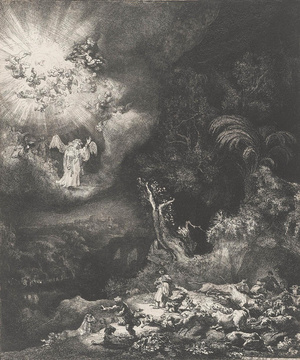

In [30]:
from PIL import Image

url = data["rows"][0]["row"]["image"]["src"]
image = Image.open(requests.get(url, stream=True).raw)
# images are way too large that make this notebook too large as well
# downscale
width = 300
ratio = (width / float(image.size[0]))
height = int((float(image.size[1]) * float(ratio)))
img = image.resize((width, height), Image.Resampling.LANCZOS)
display(img)

Below are helper functions to extract features and normalize and add the extracted embedding to index.

In [31]:
def add_vector(embedding, index):
    vector = embedding.detach().cpu().numpy()
    vector = np.float32(vector)
    faiss.normalize_L2(vector)
    index.add(vector)

def embed_siglip(image):
    with torch.no_grad():
        inputs = processor(images=image, return_tensors="pt").to(device)
        image_features = model.get_image_features(**inputs)
        return image_features


Simply iterate over the dataset.

In [32]:
from PIL import Image
from torchvision import transforms

# initialize the index with the size matching of embeddings out from the model
index = faiss.IndexFlatL2(768)

# read the image and add vector
for elem in data["rows"]:
  url = elem["row"]["image"]["src"]
  image = Image.open(requests.get(url, stream=True).raw)
  clip_features = embed_siglip(image)
  add_vector(clip_features,index)

We can save the index to query later on.

In [33]:
faiss.write_index(index,"./siglip_70k.index")

Make sure index is written properly.

In [34]:
index = faiss.read_index("./siglip_70k.index")

## Text Query

We can now query with text or image.

In [35]:
prompt="a woman"

text_token = tokenizer([prompt], return_tensors="pt").to(device)
text_features = model.get_text_features(**text_token)

text_features = text_features.detach().cpu().numpy()
text_features = np.float32(text_features)
faiss.normalize_L2(text_features)

distances, indices = index.search(text_features, 3)

In [36]:
indices

array([[50, 18, 61]])

Let's see the images closest to text query.

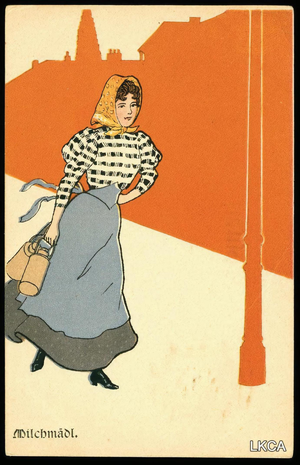

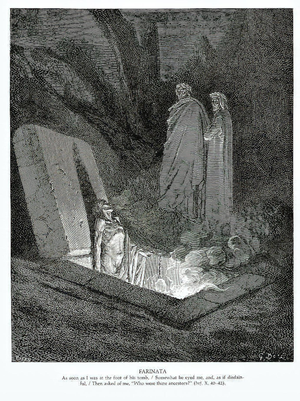

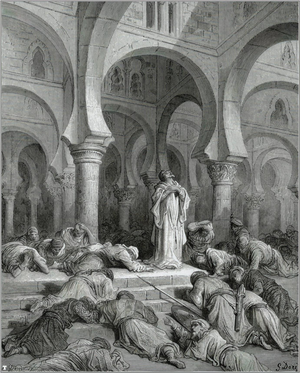

In [37]:
for elem in indices[0]:
  url = data["rows"][elem]["row"]["image"]["src"]
  image = Image.open(requests.get(url, stream=True).raw)

  # downscale
  width = 300
  ratio = (width / float(image.size[0]))
  height = int((float(image.size[1]) * float(ratio)))
  img = image.resize((width, height), Image.Resampling.LANCZOS)
  display(img)

## Image Similarity Inference

Image similarity inference is similar, where you just call `get_image_features`.

In [45]:
# image of a man
url = "https://as1.ftcdn.net/v2/jpg/01/21/37/54/1000_F_121375466_Mmy3aq1cZjWaN7G67HOhZd2I8MXaJ4cW.jpg"
image = Image.open(requests.get(url, stream=True).raw)


Search for the similar image.

In [46]:
with torch.no_grad():
  inputs = processor(images=image, return_tensors="pt").to(device)
  input_features = model.get_image_features(**inputs)

input_features = input_features.detach().cpu().numpy()
input_features = np.float32(input_features)
faiss.normalize_L2(input_features)
distances, indices = index.search(input_features, 3)


Display the most similar image to the retro woman artwork.

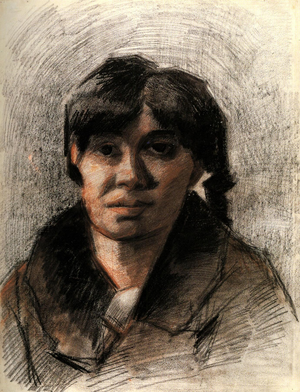

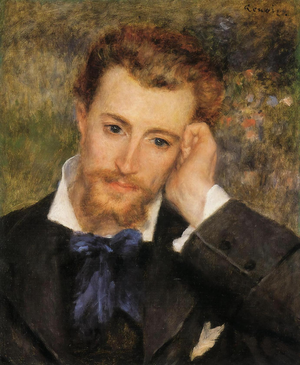

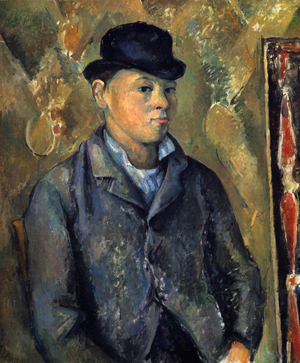

In [47]:
for elem in indices[0]:
  url = data["rows"][elem]["row"]["image"]["src"]
  image = Image.open(requests.get(url, stream=True).raw)
  width = 300
  ratio = (width / float(image.size[0]))
  height = int((float(image.size[1]) * float(ratio)))
  img = image.resize((width, height), Image.Resampling.LANCZOS)
  display(img)